In [1]:
import xarray as xr
import numpy as np
import yaml
import os
import pop_tools
import esmlab
import esmlab_regrid
esmlab.config.set({'regrid.gridfile-directory' : 'scrip_grids/'})

%matplotlib inline

Open all 12 files in `/glade/work/mclong/seawifs/chl_gsm`

```
$ ls -1
S19972442010273.L3m_MC_GSM_chl_gsm_9km.nc
S19972742010304.L3m_MC_GSM_chl_gsm_9km.nc
S19973052010334.L3m_MC_GSM_chl_gsm_9km.nc
S19973352010365.L3m_MC_GSM_chl_gsm_9km.nc
S19980012010031.L3m_MC_GSM_chl_gsm_9km.nc
S19980322010059.L3m_MC_GSM_chl_gsm_9km.nc
S19980602010090.L3m_MC_GSM_chl_gsm_9km.nc
S19980912010120.L3m_MC_GSM_chl_gsm_9km.nc
S19981212010151.L3m_MC_GSM_chl_gsm_9km.nc
S19981522010181.L3m_MC_GSM_chl_gsm_9km.nc
S19981822010212.L3m_MC_GSM_chl_gsm_9km.nc
S19982132010243.L3m_MC_GSM_chl_gsm_9km.nc
```

Note that, in order, these are

```
Sept (1997 - 2010)
Oct (1997 - 2010)
Nov (1997 - 2010)
Dec (1997 - 2010)
Jan (1998 - 2010)
Feb (1998 - 2010)
March (1998 - 2010)
April (1998 - 2010)
May (1998 - 2010)
June (1998 - 2010)
July (1998 - 2010)
Aug (1998 - 2010)
```

In [2]:
# def _smooth_invalid_values(orig_da, masked_da):
#     """
#     masked_da has np.nan instead of values > valid_max or < valid_min
#     This function replaces those nans with weighted average
#     """
#     pass

def _mask_invalid_values(ds, var = 'chl_gsm', mask_val=None, keep=True, verbose=False):
    """ replace chl_gsm values above valid_max or below valid_min with np.nan """
    da_new = ds[var].copy()
    if 'valid_min' in da_new.attrs:
        if not mask_val:
            min_mask = da_new.attrs['valid_min']
        else:
            min_mask = mask_val
        if verbose:
            print(f'adjusting minimum to {min_mask}')
        da_new.data = np.where(da_new.data < da_new.attrs['valid_min'], min_mask, da_new.data)
        if not keep:
            del(da_new.attrs['valid_min'])
    if 'valid_max' in da_new.attrs:
        if not mask_val:
            max_mask = da_new.attrs['valid_max']
        else:
            max_mask = mask_val
        if verbose:
            print(f'adjusting maximum to {max_mask}')
        da_new.data = np.where(da_new.data > da_new.attrs['valid_max'], max_mask, da_new.data)
        if not keep:
            del(da_new.attrs['valid_max'])
#     da_new = _smooth_invalid_values(ds[var], da_new)
    ds[var] = da_new
    return(ds)

In [3]:
'''
netcdf POP_gx1v7 {
dimensions:
    grid_size = 122880 ;
    grid_rank = 2 ;
    grid_corners = 4 ;
variables:
    int grid_dims(grid_rank) ;
    double grid_center_lat(grid_size) ;
        grid_center_lat:units = "radians" ;
    double grid_center_lon(grid_size) ;
        grid_center_lon:units = "radians" ;
    double grid_area(grid_size) ;
    int grid_imask(grid_size) ;
        grid_imask:units = "unitless" ;
    double grid_corner_lat(grid_size, grid_corners) ;
        grid_corner_lat:units = "radians" ;
    double grid_corner_lon(grid_size, grid_corners) ;
        grid_corner_lon:units = "radians" ;

'''

def gen_scrip_grid(ds_dicts_in, var_for_mask):
    """
        Takes lat, lon information from seaWIFS dataset and creates a SCRIP grid file
        NOTES:
        1. using "degrees_east" and "degrees_north" instead of just "degrees" caused ESMF issues
        2. I have not yet computed grid_area correctly
    """
    # Pull grid out of dataset
    lats = ds_dicts_in['Jan']['lat'].data
    nlat = len(lats)
    lons = ds_dicts_in['Jan']['lon'].data
    nlon = len(lons)
    
    # Define lat_bnds and lon_bnds (to convert to corners)
    lat_bnds = np.empty_like(lats, shape=(nlat, 2))
    lat_bnds[0, 0] = 90.
    lat_bnds[1:, 0] = 0.5*(lats[1:] + lats[:-1])
    lat_bnds[:-1, 1] = 0.5*(lats[1:] + lats[:-1])
    lat_bnds[-1, 1] = -90.
    lon_bnds = np.empty_like(lons, shape=(nlon, 2))
    lon_bnds[0, 0] = -180.
    lon_bnds[1:, 0] = 0.5*(lons[1:] + lons[:-1])
    lon_bnds[:-1, 1] = 0.5*(lons[1:] + lons[:-1])
    lon_bnds[-1, 1] = 180.

    # Define lat_corners and lon_corners
    lat_corners = np.empty_like(lats, shape=(nlat, 4))
    lat_corners[:, 0] = lat_bnds[:, 1] # SW
    lat_corners[:, 1] = lat_bnds[:, 1] # SE
    lat_corners[:, 2] = lat_bnds[:, 0] # NE
    lat_corners[:, 3] = lat_bnds[:, 0] # NW

    lon_corners = np.empty_like(lons, shape=(nlon, 4))
    lon_corners[:, 0] = lon_bnds[:, 0] # SW
    lon_corners[:, 1] = lon_bnds[:, 1] # SE
    lon_corners[:, 2] = lon_bnds[:, 1] # NE
    lon_corners[:, 3] = lon_bnds[:, 0] # NW

    # Define dimensions for xarray
    grid_size = nlat*nlon
    grid_rank = 2
    grid_dims = [nlon, nlat]

    # Set up local copies of data to add to scrip dataset
    lats_repeat = np.repeat(lats[:,np.newaxis], nlon, axis=1).reshape(nlat*nlon)
    lons_repeat = np.repeat(lons[np.newaxis,:], nlat, axis=0).reshape(nlat*nlon)
    grid_imask = np.zeros(nlat*nlon, dtype=int)
    for month in ds_dicts_in:
        grid_imask = grid_imask | np.where(np.isnan(ds_dicts_in[month][var_for_mask].data), 0, 1).reshape(nlat*nlon)
    lat_corners_repeat = np.repeat(lat_corners[:,np.newaxis,:], nlon, axis=1).reshape((nlat*nlon, 4))
    lon_corners_repeat = np.repeat(lon_corners[np.newaxis,:,:], nlat, axis=0).reshape((nlat*nlon, 4))

    # compute grid_area
    s_lat = lat_corners_repeat[:,0]*np.pi/180 # SW
    n_lat = lat_corners_repeat[:,2]*np.pi/180 # NE
    w_lon = lon_corners_repeat[:,0]*np.pi/180 # SW
    e_lon = lon_corners_repeat[:,2]*np.pi/180 # NE
    grid_area = (np.sin(n_lat) - np.sin(s_lat))*(e_lon - w_lon)

    # Need to create scrip_ds
    scrip_ds = xr.Dataset()
    scrip_ds['grid_dims'] = xr.DataArray(grid_dims, dims='grid_rank')
    scrip_ds['grid_center_lon'] = xr.DataArray(lons_repeat, dims='grid_size')
    scrip_ds['grid_center_lat'] = xr.DataArray(lats_repeat, dims='grid_size')
    scrip_ds['grid_imask'] = xr.DataArray(grid_imask, dims='grid_size')
    scrip_ds['grid_corner_lon'] = xr.DataArray(lon_corners_repeat, dims=('grid_size', 'grid_corners'))
    scrip_ds['grid_corner_lat'] = xr.DataArray(lat_corners_repeat, dims=('grid_size', 'grid_corners'))
    scrip_ds['grid_area'] = xr.DataArray(grid_area, dims='grid_size')

    # Set units
    scrip_ds['grid_center_lon'].attrs['units'] = 'degrees'
    scrip_ds['grid_center_lat'].attrs['units'] = 'degrees'
    scrip_ds['grid_corner_lon'].attrs['units'] = 'degrees'
    scrip_ds['grid_corner_lat'].attrs['units'] = 'degrees'
    scrip_ds['grid_area'].attrs['units'] = 'radians^2'

    return scrip_ds

In [4]:
# Read mapping_dict from YAML
with open('mapping_dict.yaml') as yaml_file:
    mapping_dict = yaml.safe_load(yaml_file)

# Read monthly files
dict_of_datasets = dict()
for n, month in enumerate(mapping_dict):
    file_loc = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'seaWIFS-data', 'chl_gsm', mapping_dict[month]['file'])
    dict_of_datasets[month] = xr.open_dataset(file_loc)

# Generate scrip dataset
scrip_in = gen_scrip_grid(dict_of_datasets, 'chl_gsm')
outfile = 'scrip_grids/seaWIFS.nc'
os.system(f'rm -f {outfile}')
scrip_in.to_netcdf('scrip_grids/seaWIFS.nc')

# Reasonable area?
print(f'Surface area (grid): {np.sum(scrip_in["grid_area"].data)}\nSurface area (true): {4*np.pi}')

Surface area (grid): 12.566378593444824
Surface area (true): 12.566370614359172


In [5]:
%%time

# delete ann_sum, DJF_sum, and JJA_sum if they exist
try:
    del(ann_sum)
except:
    pass
try:
    del(DJF_sum)
except:
    pass
try:
    del(DJF_sum)
except:
    pass

# Filter out invalid values from monthly dataset, then compute annual and seasonal (DJF, JJA) means
for n, month in enumerate(mapping_dict):
    dict_of_datasets[month] = _mask_invalid_values(dict_of_datasets[month], mask_val=np.nan)
    try:
        ann_sum = ann_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
        ann_wgt_sum = ann_wgt_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)
    except:
        ann_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
        ann_wgt_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)
    if month in ['Dec', 'Jan', 'Feb']:
        try:
            DJF_sum = DJF_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
            DJF_wgt_sum = DJF_wgt_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)
        except:
            DJF_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
            DJF_wgt_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)
    if month in ['Jun', 'Jul', 'Aug']:
        try:
            JJA_sum = JJA_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
            JJA_wgt_sum = JJA_wgt_sum + np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)
        except:
            JJA_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), dict_of_datasets[month]['chl_gsm'].data * mapping_dict[month]['len'], 0)
            JJA_wgt_sum = np.where(np.logical_not(np.isnan(dict_of_datasets[month]['chl_gsm'].data)), mapping_dict[month]['len'], 0)

print(f'Annual average based on {ann_wgt_sum.max()} days in the year')
print(f'DJF average based on {DJF_wgt_sum.max()} days in the year')
print(f'JJA average based on {JJA_wgt_sum.max()} days in the year')
ann_ds = dict_of_datasets[list(mapping_dict.keys())[0]].copy()
ann_ds['chl_gsm'].data = np.where(ann_wgt_sum == ann_wgt_sum.max(), ann_sum / ann_wgt_sum, np.nan)
DJF_ds = dict_of_datasets[list(mapping_dict.keys())[0]].copy()
DJF_ds['chl_gsm'].data = np.where(DJF_wgt_sum == DJF_wgt_sum.max(), DJF_sum / DJF_wgt_sum, np.nan)
JJA_ds = dict_of_datasets[list(mapping_dict.keys())[0]].copy()
JJA_ds['chl_gsm'].data = np.where(JJA_wgt_sum == JJA_wgt_sum.max(), JJA_sum / JJA_wgt_sum, np.nan)

# strip out invalid values
ann_ds = _mask_invalid_values(ann_ds, mask_val=np.nan)

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


Annual average based on 365 days in the year
DJF average based on 90 days in the year
JJA average based on 92 days in the year


/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 2.2 s, sys: 4.85 s, total: 7.04 s
Wall time: 8.37 s


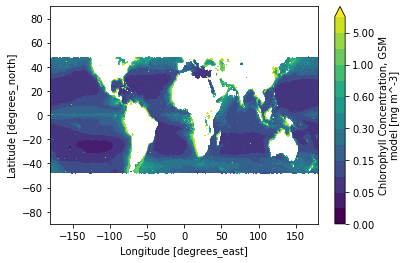

In [6]:
ann_ds['chl_gsm'].plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]);

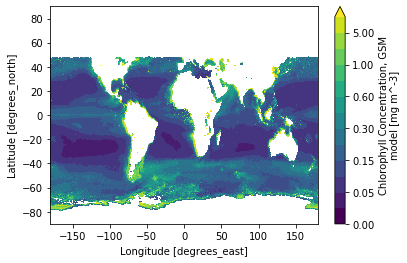

In [7]:
DJF_ds['chl_gsm'].plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]);

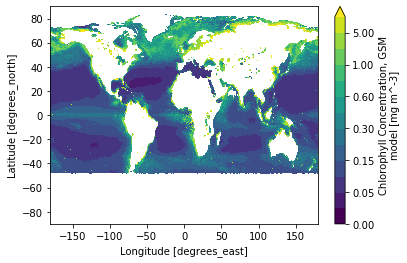

In [8]:
JJA_ds['chl_gsm'].plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]);

In [9]:
# Note: I ended up building this file in parallel using the CIME mapping tools
# $ qcmd -- ./create_ESMF_map.sh -fsrc /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/seaWIFS.nc \
#                                -fdst /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/POP_gx1v7.nc \
#                                -nsrc seaWIFS -ndst POP_gx1v7 -map aave
# which lead to
# $ mpirun -np 36 ESMF_RegridWeightGen --ignore_unmapped -m bilinear -w map_seaWIFS_TO_POP_gx1v7_blin.200205.nc \
#                                      -s /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/seaWIFS.nc \
#                                      -d /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/POP_gx1v7.nc
# followed by
# $ cp map_seaWIFS_TO_POP_gx1v7_aave.200205.nc /glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/weights/seaWIFS_to_POP_gx1v7_conservative.nc
regrid_operator = esmlab_regrid.regridder(name_grid_src='seaWIFS',
                                          name_grid_dst='POP_gx1v7', 
                                          method='conservative',
                                          overwrite_existing=False)


In [10]:
%%time

list_of_mapped_das = []
for month in dict_of_datasets:
    print(f'Interpolating data from {month}')
    list_of_mapped_das.append(regrid_operator(dict_of_datasets[month]['chl_gsm'], renormalize=True, apply_mask=True).rename({'lat' : 'nlat', 'lon' : 'nlon'}))

print('Interpolating annual data')
mapped_ann_da = regrid_operator(ann_ds['chl_gsm'], renormalize=True, apply_mask=True).rename({'lat' : 'nlat', 'lon' : 'nlon'})

print('Interpolating DJF data')
mapped_DJF_da = regrid_operator(DJF_ds['chl_gsm'], renormalize=True, apply_mask=True).rename({'lat' : 'nlat', 'lon' : 'nlon'})

print('Interpolating JJA data')
mapped_JJA_da = regrid_operator(JJA_ds['chl_gsm'], renormalize=True, apply_mask=True).rename({'lat' : 'nlat', 'lon' : 'nlon'})

Interpolating data from Jan
Interpolating data from Feb
Interpolating data from Mar
Interpolating data from Apr
Interpolating data from May
Interpolating data from Jun
Interpolating data from Jul
Interpolating data from Aug
Interpolating data from Sep
Interpolating data from Oct
Interpolating data from Nov
Interpolating data from Dec
Interpolating annual data
Interpolating DJF data
Interpolating JJA data
CPU times: user 1.69 s, sys: 3.35 s, total: 5.04 s
Wall time: 5.25 s


In [11]:
def _clean_up_new_dataset(ds):
    # 1) Clean up metadata -- remove unneeded global attributes as well as coordinates attribute from all variables that have it
    del(ds.attrs['region_mask_regions'])
    del(ds.attrs['topography_fname'])
    for var in ds.variables:
        if 'coordinates' in ds[var].attrs:
            del(ds[var].attrs['coordinates'])

    # 4) Enforce valid_min and valid_max (this would only be triggered due to mapping,
    #    so I don't think it's appropriate to replace with min and max rather than nan)
    ds = _mask_invalid_values(ds, keep=False)

    # 5) Print resulting dataset to screen
    print(f"Min value of chl_gsm: {np.nanmin(ds['chl_gsm'].data)}")
    print(f"Max value of chl_gsm: {np.nanmax(ds['chl_gsm'].data)}")

    return(ds)

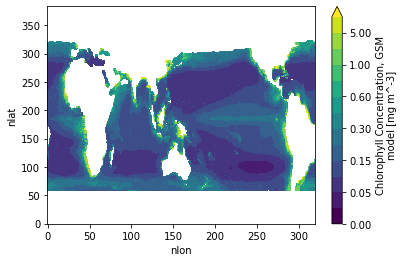

In [12]:
mapped_ann_da.plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]);

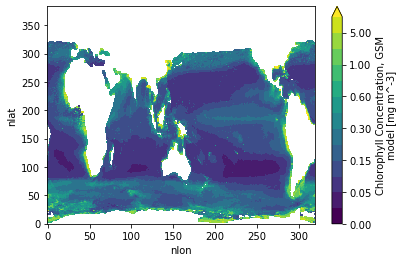

In [13]:
mapped_DJF_da.plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]);

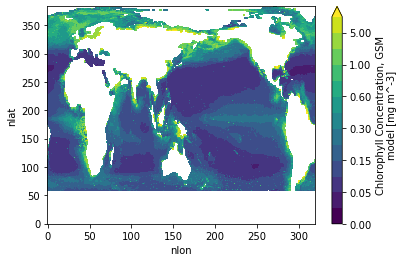

In [14]:
mapped_JJA_da.plot(levels=[0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 2, 5, 20]);

In [15]:
# 1) Create template for dataset on POP grid
#    Note that I remove all variables on vertical grid and dual grid, then promote TLAT and TLONG to coordinates
ds_new = pop_tools.get_grid(grid_name='POP_gx1v7').drop(['dz', 'z_t', 'z_w', 'z_w_bot', 'KMT', 'ULAT', 'ULONG']).set_coords(['TLAT', 'TLONG'])
ds_ann_new = pop_tools.get_grid(grid_name='POP_gx1v7').drop(['dz', 'z_t', 'z_w', 'z_w_bot', 'KMT', 'ULAT', 'ULONG']).set_coords(['TLAT', 'TLONG'])
ds_DJF_new = pop_tools.get_grid(grid_name='POP_gx1v7').drop(['dz', 'z_t', 'z_w', 'z_w_bot', 'KMT', 'ULAT', 'ULONG']).set_coords(['TLAT', 'TLONG'])
ds_JJA_new = pop_tools.get_grid(grid_name='POP_gx1v7').drop(['dz', 'z_t', 'z_w', 'z_w_bot', 'KMT', 'ULAT', 'ULONG']).set_coords(['TLAT', 'TLONG'])

# 2) Concatenate remapped data arrays over new dimension named time
#    TODO: figure out best values for time (currently an array of str)
ds_new['chl_gsm'] = xr.concat(list_of_mapped_das, dim='month')
ds_new['month'] = [month for month in dict_of_datasets]
ds_ann_new['chl_gsm'] = mapped_ann_da
ds_DJF_new['chl_gsm'] = mapped_DJF_da
ds_JJA_new['chl_gsm'] = mapped_JJA_da

# 3) more dataset cleanup
ds_new = _clean_up_new_dataset(ds_new)
ds_ann_new = _clean_up_new_dataset(ds_ann_new)
ds_DJF_new = _clean_up_new_dataset(ds_DJF_new)
ds_JJA_new = _clean_up_new_dataset(ds_JJA_new)

# 4) Generate netCDF file
#    TODO: come up with a better file name
ds_new.to_netcdf('seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc')
ds_ann_new.to_netcdf('seaWIFS.chl_gsm.ann_climo.Sep1997_Dec2010.nc')
ds_DJF_new.to_netcdf('seaWIFS.chl_gsm.DJF_climo.Sep1997_Dec2010.nc')
ds_JJA_new.to_netcdf('seaWIFS.chl_gsm.JJA_climo.Sep1997_Dec2010.nc')

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


Min value of chl_gsm: 0.002594604389742017
Max value of chl_gsm: 99.73515978449157
Min value of chl_gsm: 0.03706707208345628
Max value of chl_gsm: 39.290454746419925
Min value of chl_gsm: 0.02890429948320631
Max value of chl_gsm: 65.91252164662451
Min value of chl_gsm: 0.04227025876078959
Max value of chl_gsm: 65.45590592734202
